In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.cm as cm
import random
import glob
import os
from skimage.segmentation import chan_vese
import numpy as np
import PIL 
from PIL import Image 
from tensorboard.plugins.hparams import api as hp
import pandas as pd
from shutil import copy

# Display
# from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# My functions
import my_functions as mf

# tf explain
from tf_explain.callbacks.grad_cam import GradCAMCallback

In [2]:
random_seed = 42

In [3]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [4]:
covid_metadata = pd.read_csv('datasets\ct_scan_3\meta_data_covid.csv')
non_covid_metadata = pd.read_csv('datasets\ct_scan_3\meta_data_normal.csv')

## Split images

In [5]:
train_covid_patients_ids, val_covid_patients_ids = mf.random_split_patients(covid_metadata['Patient ID'].unique(), 0.2, seed=random_seed)

In [6]:
for patient in train_covid_patients_ids:
   mf.copy_all_images_from_one_patient(
      patient_id=patient, 
      src_folder='datasets\\ct_scan_3\\full-COVID-positive', 
      dst_folder='datasets\\ct_scan_3\\train\\COVID-positive', 
      metadata=covid_metadata)

Copy error: [Errno 2] No such file or directory: 'datasets\\ct_scan_3\\full-COVID-positive\\17_Zhao_impact_of_covid19_infection_on_pregnancy_outcomes_and_the_risk_of_maternaltoneonatal_intrapartum_transmission_of_covid19_during_natural_birth-p8-41%1.png'
Copy error: [Errno 2] No such file or directory: 'datasets\\ct_scan_3\\full-COVID-positive\\17_Zhao_impact_of_covid19_infection_on_pregnancy_outcomes_and_the_risk_of_maternaltoneonatal_intrapartum_transmission_of_covid19_during_natural_birth-p8-41%3.png'


In [8]:
for patient in val_covid_patients_ids:
   mf.copy_all_images_from_one_patient(
      patient_id=patient, 
      src_folder='datasets\\ct_scan_3\\full-COVID-positive', 
      dst_folder = 'datasets\\ct_scan_3\\val\\COVID-positive', 
      metadata = covid_metadata)

Copy error: [Errno 2] No such file or directory: 'datasets\\ct_scan_3\\full-COVID-positive\\17_Zhao_impact_of_covid19_infection_on_pregnancy_outcomes_and_the_risk_of_maternaltoneonatal_intrapartum_transmission_of_covid19_during_natural_birth-p8-41%5.png'


In [10]:
train_non_covid_patients_ids, val_non_covid_patients_ids = mf.random_split_patients(non_covid_metadata['Patient ID'].unique(), 0.2, seed=random_seed)

In [12]:
for patient in train_non_covid_patients_ids:
   mf.copy_all_images_from_one_patient(
      patient_id=patient, 
      src_folder='datasets\\ct_scan_3\\full-COVID-negative', 
      dst_folder='datasets\\ct_scan_3\\train\\COVID-negative', 
      metadata=non_covid_metadata)

In [14]:
for patient in val_non_covid_patients_ids:
   mf.copy_all_images_from_one_patient(
      patient_id=patient, 
      src_folder='datasets\\ct_scan_3\\full-COVID-negative', 
      dst_folder='datasets\\ct_scan_3\\val\\COVID-negative', 
      metadata=non_covid_metadata)

## Check split

In [6]:
default_dir = "datasets\\ct_scan_3\\"

n_train_positive = len(os.listdir(default_dir + "train\\COVID-positive"))
n_train_negative = len(os.listdir(default_dir + "train\\COVID-negative"))
n_val_positive = len(os.listdir(default_dir + "val\\COVID-positive"))
n_val_negative = len(os.listdir(default_dir + "val\\COVID-negative"))

n_original_covid_positive = len(os.listdir(default_dir + "full-COVID-positive"))
n_original_covid_negative = len(os.listdir(default_dir + "full-COVID-negative"))

In [7]:
n_train_positive + n_val_positive == n_original_covid_positive

True

In [8]:
n_train_negative + n_val_negative == n_original_covid_negative

True

## Real train val split ratio

In [14]:
(n_val_positive + n_val_negative) / (n_train_positive + n_train_negative)

0.22209096278795037

## Datasets objects

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
   'datasets/ct_scan_3/train',
   labels='inferred',
   label_mode='int',
   class_names=None,
   color_mode='rgb',
   batch_size=batch_size,
   image_size=image_size,
   shuffle=True, 
   seed=random_seed, 
   interpolation='bilinear',
   follow_links=False,
   crop_to_aspect_ratio=False)

Found 11851 files belonging to 2 classes.


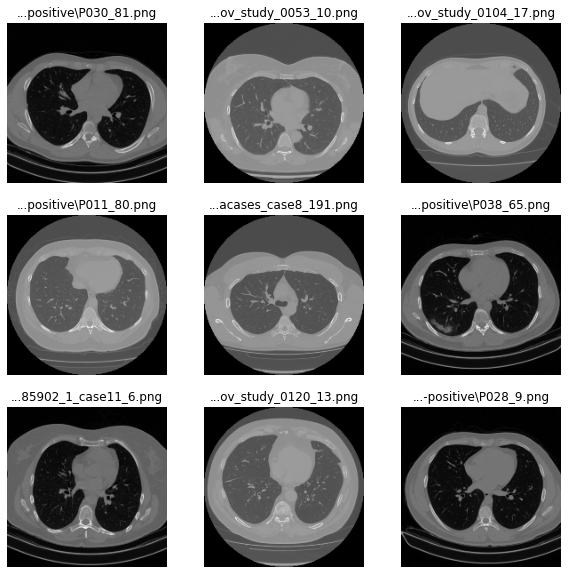

In [10]:
mf.check_dataset(train_ds)

In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
   'datasets/ct_scan_3/val',
   labels='inferred',
   label_mode='int',
   class_names=None,
   color_mode='rgb',
   batch_size=batch_size,
   image_size=image_size,
   shuffle=True, 
   seed=random_seed,
   interpolation='bilinear',
   follow_links=False,
   crop_to_aspect_ratio=False)

Found 2632 files belonging to 2 classes.


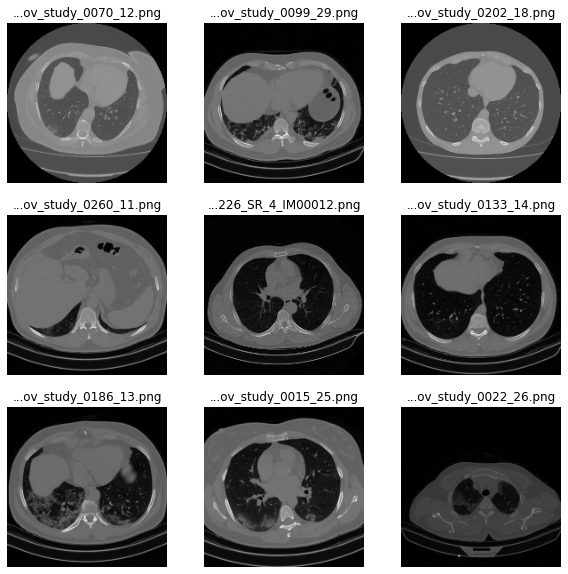

In [12]:
mf.check_dataset(val_ds)

## Model architecture

In [15]:
inputs = keras.Input(shape=(img_height, img_width, 3))

data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"), 
      layers.RandomRotation(0.1)
    ]
)
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(x)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    input_tensor=x
)
last_layer_base_model = mf.find_last_layer(base_model)

x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_base_model.output)

x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=32, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

base_model.trainable = False # Freeze base model

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         rescaling[0][0]                  
______________________________________________________________________________________________

In [ ]:
gcam_image_path = "datasets\\ct_scan_3\\val\\COVID-positive\\P021_106.png"

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

run_logdir = mf.get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

data = (mf.get_img_array(gcam_image_path, image_size), None)
grd_cam_callback = GradCAMCallback(
   validation_data=data,
   class_index=0,
   output_dir=run_logdir,
)

epochs = 100
base_model.trainable = False
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[
      tensorboard_cb, 
      early_stopping_cb, 
      grd_cam_callback])

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

run_logdir = mf.get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

data = (mf.get_img_array(gcam_image_path, image_size), None)
grd_cam_callback = GradCAMCallback(
   validation_data=data,
   class_index=0,
   output_dir=run_logdir,
)

epochs = 100
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
     callbacks=[
      tensorboard_cb, 
      early_stopping_cb, 
      grd_cam_callback])

run_modeldir = mf.get_model_dir()
model.save(run_modeldir)

# Testing model behavior

In [ ]:
model = keras.models.load_model("my_models\\model_0")
explainer = GradCAM()

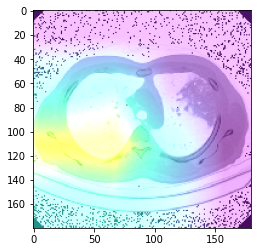

In [46]:
IMAGE_PATH = "datasets\\ct_scan_3\\val\\COVID-positive\\P021_106.png"
data = (mf.get_img_array(IMAGE_PATH, image_size), None)
grid = explainer.explain(data, model, class_index=0, use_guided_grads=False)
plt.imshow(grid, cmap='binary')

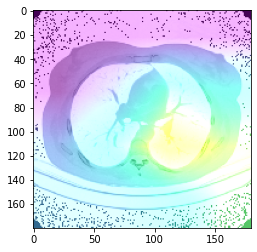

In [57]:
IMAGE_PATH = "datasets\\ct_scan_3\\val\\COVID-negative\\normal034_95.png"
data = (mf.get_img_array(IMAGE_PATH, image_size), None)
grid = explainer.explain(data, model, class_index=0, use_guided_grads=True)
plt.imshow(grid, cmap='binary')

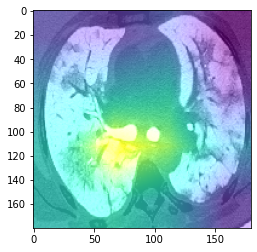

In [39]:
IMAGE_PATH = "datasets\ct_scan_1\datasetsSARS-COV-2 Ct-Scan\COVID-positive\Covid (2).png"
data = (mf.get_img_array(IMAGE_PATH, image_size), None)
grid = explainer.explain(data, model, class_index=0)
plt.imshow(grid, cmap='binary')

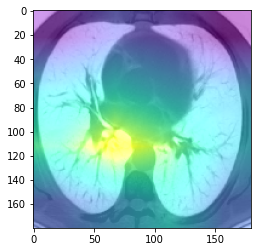

In [53]:
IMAGE_PATH = "datasets\\ct_scan_1\\datasetsSARS-COV-2 Ct-Scan\\COVID-negative\\Non-Covid (100).png"
data = (mf.get_img_array(IMAGE_PATH, image_size), None)
grid = explainer.explain(data, model, class_index=0, use_guided_grads=False)
plt.imshow(grid, cmap='binary')

# Building segmentation dataset

In [5]:
mf.aply_segmentation_to_folder(
   original_folder_path="datasets\\ct_scan_4\\val\\COVID-positive\\"
   ,destination_folder_path="datasets\\ct_scan_4\\val_seg\\COVID-positive\\"
   ,init_level_set='checkerboard')

Current_image: datasets\ct_scan_4\val\COVID-positive\13_Bjorke_100.png
Current_image: datasets\ct_scan_4\val\COVID-positive\13_Bjorke_13.png
Current_image: datasets\ct_scan_4\val\COVID-positive\13_Bjorke_15.png


KeyboardInterrupt: 

In [38]:
img_path = "datasets\\ct_scan_4\\val\COVID-positive\\6_Rahimzadeh_137covid_patient9_SR_4_IM00026.png"

In [19]:
img = keras.preprocessing.image.load_img(img_path)
img_array = keras.preprocessing.image.img_to_array(img)
sample_slice = img_array[:, :, 0]
normalize_slice = np.true_divide(sample_slice, [255.0], out=None)

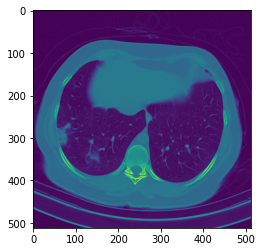

In [21]:
plt.imshow(normalize_slice)

In [40]:
normalize_slice.shape

(512, 512)

In [42]:
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa
from skimage.morphology import disk  # noqa


In [49]:
orig_phantom = normalize_slice

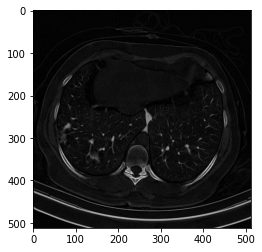

In [83]:
img_path = "datasets\\ct_scan_4\\val\COVID-positive\\6_Rahimzadeh_137covid_patient9_SR_4_IM00026.png"
img = keras.preprocessing.image.load_img(img_path)
img_array = keras.preprocessing.image.img_to_array(img)
sample_slice = img_array[:, :, 0]
normalize_slice = np.true_divide(sample_slice, [255.0], out=None)
orig_phantom = normalize_slice
footprint = disk(12)
w_tophat = white_tophat(orig_phantom, footprint)
plt.imshow(w_tophat, cmap='gray')

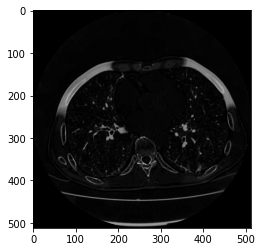

In [82]:
img_path = "datasets\\ct_scan_4\\val\COVID-positive\\16_Morozov_study_0270_19.png"
img = keras.preprocessing.image.load_img(img_path)
img_array = keras.preprocessing.image.img_to_array(img)
sample_slice = img_array[:, :, 0]
normalize_slice = np.true_divide(sample_slice, [255.0], out=None)
orig_phantom = normalize_slice
footprint = disk(12)
w_tophat = white_tophat(orig_phantom, footprint)
plt.imshow(w_tophat, cmap='gray')

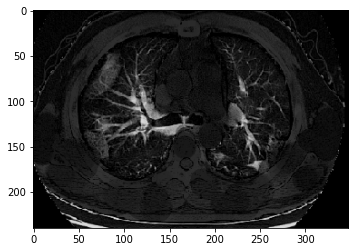

In [85]:
img_path = "datasets\\ct_scan_4\\val\COVID-positive\\17_Zhao_2020.03.04.20026005-p12-1946%3.png"
img = keras.preprocessing.image.load_img(img_path)
img_array = keras.preprocessing.image.img_to_array(img)
sample_slice = img_array[:, :, 0]
normalize_slice = np.true_divide(sample_slice, [255.0], out=None)
orig_phantom = normalize_slice
footprint = disk(12)
w_tophat = white_tophat(orig_phantom, footprint)
plt.imshow(w_tophat, cmap='gray')

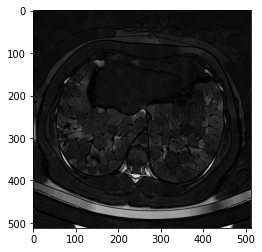

In [75]:
footprint = disk(10)
b_tophat = black_tophat(orig_phantom, footprint)
plt.imshow(b_tophat, cmap='gray')